In [90]:
import pandas as pd
from string import punctuation
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
import recordlinkage
from nltk.corpus import stopwords
lemma = WordNetLemmatizer()


df = pd.read_csv('data/training_data.csv')
df['Category']=df['label'].replace({0:'TA',1:'Malware',2:'tool'})
df.rename(columns={'Name':'name'},inplace=True)

In [91]:
df.head()

,name,Description,label,Category
0,admin@338,G0018 admin@338 is a China-based cyber threat ...,0,TA
1,apt1,G0006 APT1 is a Chinese threat group that has ...,0,TA
2,apt12,G0005 APT12 is a threat group that has been at...,0,TA
3,apt16,G0023 APT16 is a China-based threat group that...,0,TA
4,apt17,G0025 APT17 is a China-based threat group that...,0,TA


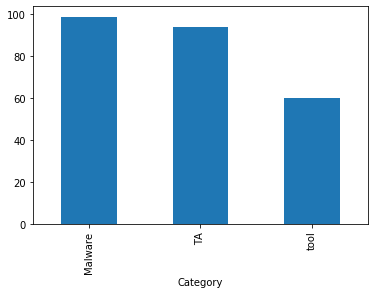

In [92]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
df.groupby('Category').Description.count().plot.bar(ylim=0)
plt.show()

In [93]:
#function to preprocess th data
def text_preprocessing(df):
    stop_words = stopwords.words("english")+list(punctuation) # segregation stopwords and punctuations
    tokens=[]
    for index,row in df.iterrows():
        text = row['Description']
        words = [w.lower() for sent in nltk.sent_tokenize(str(text)) for w in nltk.word_tokenize(sent)] #applying tokenization
        words = [w for w in words if w not in stop_words and w.isalnum()] # removing stopwords and only alphanumeric
        words = [w for w in words if len(w)>1] #removing if length is less than 1
        words = [lemma.lemmatize(w,'v') for w in words ] # applying lemmatization
        df['Description'][index] = ' '.join(words)
        tokens.extend(words)
        
    return df

In [94]:
#df_clean = text_preprocessing(df)
df_clean = df

In [95]:
df_clean

,name,Description,label,Category
0,admin@338,G0018 admin@338 is a China-based cyber threat ...,0,TA
1,apt1,G0006 APT1 is a Chinese threat group that has ...,0,TA
2,apt12,G0005 APT12 is a threat group that has been at...,0,TA
3,apt16,G0023 APT16 is a China-based threat group that...,0,TA
4,apt17,G0025 APT17 is a China-based threat group that...,0,TA
...,...,...,...,...
248,uacme,uacme uacme is an open source assessment tool...,2,tool
249,windows credential editor,windows credential editor wce windows credenti...,2,tool
250,winexe,"winexe winexe is a lightweight, open source t...",2,tool
251,xbot,xbot xbot is an android malware family that w...,2,tool


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


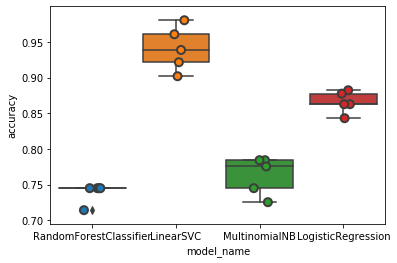

model_name
LinearSVC                 0.940696
LogisticRegression        0.865706
MultinomialNB             0.762945
RandomForestClassifier    0.738936
Name: accuracy, dtype: float64

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
import seaborn as sns

X=df_clean['Description']
Y=df_clean['Category']

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X)
tfidf_transformer = TfidfTransformer(sublinear_tf=True)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
entries=[]
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_train_tfidf, Y, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)

plt.show()
#print(cv_df)
cv_df.groupby('model_name').accuracy.mean()

0.9473684210526315


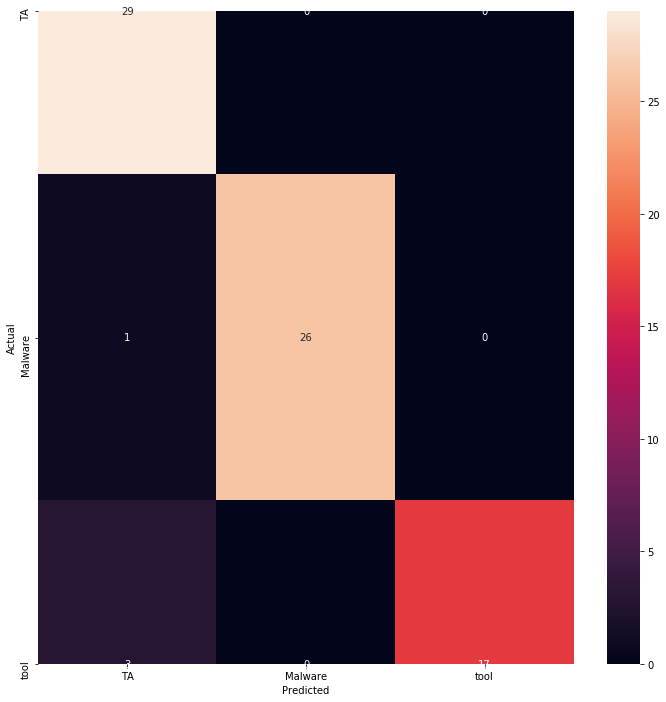

In [110]:
model = LinearSVC ()
X_train, X_test, y_train, y_test = train_test_split(df['Description'], df['Category'], test_size=0.30, random_state=110)

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts =  count_vect.transform(X_test)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

model = model.fit(X_train_tfidf, y_train)
y_pred = model.predict(X_test_tfidf)

from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test,y_pred)
print(acc)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=df_clean['Category'].unique(), yticklabels=df_clean['Category'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [77]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Category'].unique()))

              precision    recall  f1-score   support

          TA       0.88      1.00      0.94        29
     Malware       1.00      0.96      0.98        27
        tool       1.00      0.85      0.92        20

    accuracy                           0.95        76
   macro avg       0.96      0.94      0.95        76
weighted avg       0.95      0.95      0.95        76



In [78]:
test_data ="""Lazarus Group is a threat group that has been attributed to the North Korean government.[1] The group has been active since at least 2009 and was reportedly responsible for the November 2014 destructive wiper attack against Sony Pictures Entertainment as part of a campaign named Operation Blockbuster by Novetta. Malware used by Lazarus Group correlates to other reported campaigns, including Operation Flame, Operation 1Mission, Operation Troy, DarkSeoul, and Ten Days of Rain. [2] In late 2017, Lazarus Group used KillDisk, a disk-wiping tool, in an attack against an online casino based in Central America. [3] North Korean group definitions are known to have significant overlap, and the name Lazarus Group is known to encompass a broad range of activity. Some organizations use the name Lazarus Group to refer to any activity attributed to North Korea.[1] Some organizations track North Korean clusters or groups such as Bluenoroff,[4] APT37, and APT38 separately, while other organizations may track some activity associated with those group names by the name Lazarus Group."""

In [79]:
c = count_vect.transform([test_data])
tfidf = tfidf_transformer.transform(c)
prediction=list(model.predict(tfidf))[0]

In [80]:
prediction

'Malware'

In [107]:
def probability_predictions(df_clean,prediction,test):
    
    if prediction == 'TA':
        df_check=df_clean[df['Category']=='TA']
    if prediction == 'Malware':
        df_check=df_clean[df['Category']=='Malware']
    if prediction == 'tool':   
        df_check=df_clean[df['Category']=='tool']
    if prediction == None:
        df_check = df_clean
        
        
    df_check['ID'] = ['ID'+str(i) for i in range(len(df_check))]
    named_dict=dict()
    for index,row in df_check.iterrows():
        named_dict[row['ID']]= row['name']
        
    sentences=[]
    name=[]
    count=0
    for text in test:
        stop_words = stopwords.words("english")+list(punctuation)
        words = [w.lower() for sent in nltk.sent_tokenize(str(text)) for w in nltk.word_tokenize(sent)] #applying tokenization
        words = [w for w in words if w not in stop_words and w.isalnum()] # removing stopwords and only alphanumeric
        words = [w for w in words if len(w)>1] #removing if length is less than 1
        tokens = [lemma.lemmatize(w,'v')  for w in words]
        sentences.append(' '.join(tokens))
        name.append('ID_new'+str(count))
        count+=1
        
    df_test = pd.DataFrame({'ID':name,'Description':sentences})
    df_test.set_index('ID',inplace=True)
    df_check.set_index('ID',inplace=True)
        
    indexer = recordlinkage.Index()
    indexer.full()
    print(df_check.index)
    print(df_test.index)
    index_links = indexer.index(df_check, df_test)
    
    comp = recordlinkage.Compare()
    comp.string('Description', 'Description', method='levenshtein',label='Distance')
    prob=comp.compute(index_links, df_check, df_test)
    
    result=prob.sort_values(['Distance'], ascending=True)
    result.reset_index(inplace=True)
    result.rename(columns={'ID_1':'Predicted','ID_2':'Actual'},inplace=True)

    result['Predicted'].replace(named_dict,inplace=True)
    return result[0:5]  

In [108]:
probability_predictions(df_clean,prediction=None,test=[test_data])

Index(['ID0', 'ID1', 'ID2', 'ID3', 'ID4', 'ID5', 'ID6', 'ID7', 'ID8', 'ID9',
       ...
       'ID243', 'ID244', 'ID245', 'ID246', 'ID247', 'ID248', 'ID249', 'ID250',
       'ID251', 'ID252'],
      dtype='object', name='ID', length=253)
Index(['ID_new0'], dtype='object', name='ID')


,Predicted,Actual,Distance
0,dendroid,ID_new0,0.501979
1,dok,ID_new0,0.505703
2,fgdump,ID_new0,0.506371
3,denis,ID_new0,0.507979
4,exodus,ID_new0,0.510335


In [82]:
sentences=[]
name=[]
count=0
for text in [test_data]:
        stop_words = stopwords.words("english")+list(punctuation)
        words = [w.lower() for sent in nltk.sent_tokenize(str(text)) for w in nltk.word_tokenize(sent)] #applying tokenization
        words = [w for w in words if w not in stop_words and w.isalnum()] # removing stopwords and only alphanumeric
        words = [w for w in words if len(w)>1] #removing if length is less than 1
        tokens = [lemma.lemmatize(w,'v')  for w in words]
        sentences.append(' '.join(tokens))
        name.append('unknown'+str(count))
        count+=1
        
df_test = pd.DataFrame({'name':name,'Description':sentences})
df_test.set_index('name',inplace=True)

In [83]:
df_test

,Description
name,
unknown0,lazarus group threat group attribute north kor...


In [86]:
df_clean.loc['apt1']

Description    G0006 APT1 is a Chinese threat group that has ...
label                                                          0
Category                                                      TA
Name: apt1, dtype: object

In [87]:
indexer = recordlinkage.Index()
indexer.full()
index_links = indexer.index(df_clean, df_test)
    

ValueError: index of DataFrame is not unique

In [96]:
df_clean['name'].value_counts()

carbanak        2
coraldeck       1
felixroot       1
coreshell       1
dark caracal    1
               ..
apt30           1
braintest       1
apt38           1
fin10           1
dust storm      1
Name: name, Length: 252, dtype: int64